# Vector analysis — 1. Peak finding
Tina Bergh (tina.bergh@ntnu.no)

Import required packages

In [1]:
%matplotlib inline

import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import hyperspy.api as hs
import pyxem as pxm

Print the used versions of hyperspy (1.7.3) and pyxem (0.14.2)

In [2]:
print('Hyperspy version: '+str(hs.__version__)+'. Pyxem version: '+str(pxm.__version__))

Hyperspy version: 1.7.3. Pyxem version: 0.14.2


## Load the pre-processed SPED Dataset A

In [3]:
folder = './/'
file = 'datasetA_preprocessed'
dp = hs.load(folder + file + '.hspy')

Inspect the axes manager and the defined calibrations 

In [4]:
dp.axes_manager

Navigation axis name,size,index,offset,scale,units
x,512,0,0.0,2.4943,nm
y,512,0,0.0,2.4943,nm
Signal axis name,size,,offset,scale,units
kx,128,,-1.2138000000000002,0.01904,$A^{-1}$
ky,128,,-1.2138000000000002,0.01904,$A^{-1}$


Plot the SPED dataset

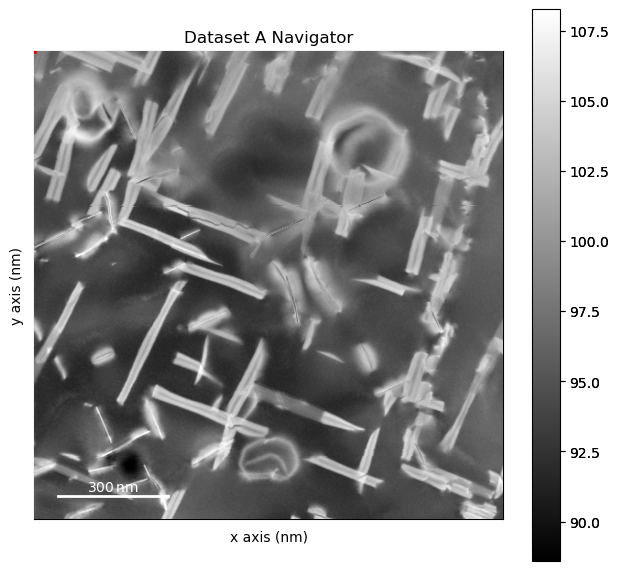

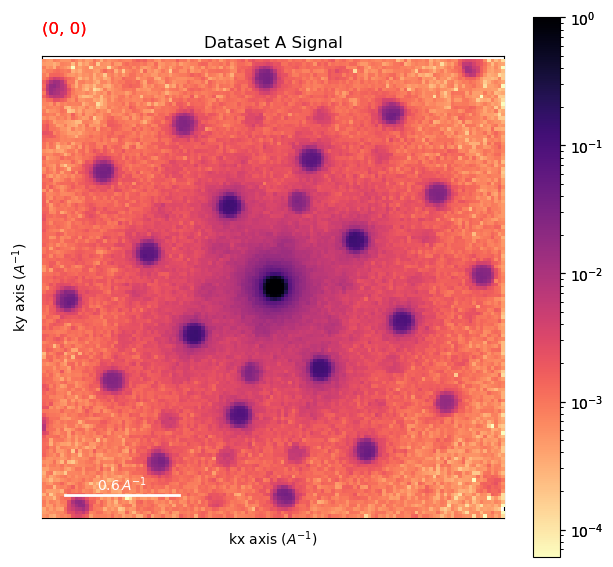

In [5]:
dp.plot(cmap='magma_r', norm='log')

# 1. Find all Bragg peaks

We use Laplacian of Gaussian blob finding to detect all Bragg peaks in the dataset, and it is important to choose the parameters correctly to include weak Bragg spots, while exclusing noise. 

First, plot the dataset and check the peak finding parameters interactively. (Note that the interactive plotting is not deleting the previous peaks when moving to a new navigation position, so close the plot and rerun the cell below after moving to a new navigation position, to plot the correct result.)

<BaseSignal, title: , dimensions: (512, 512|)>

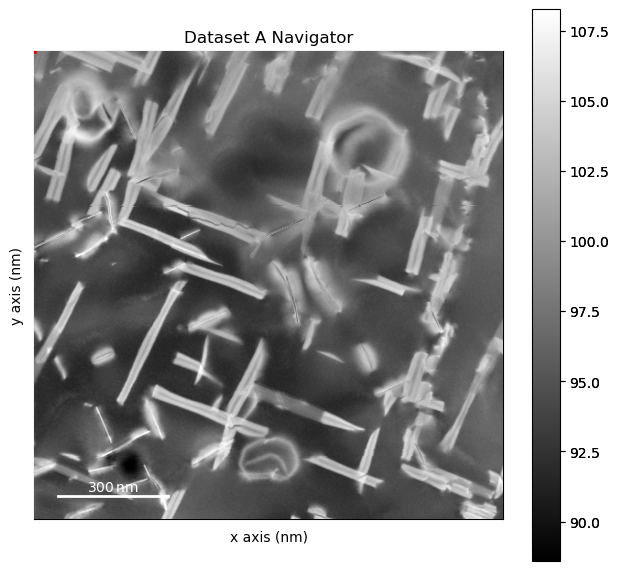

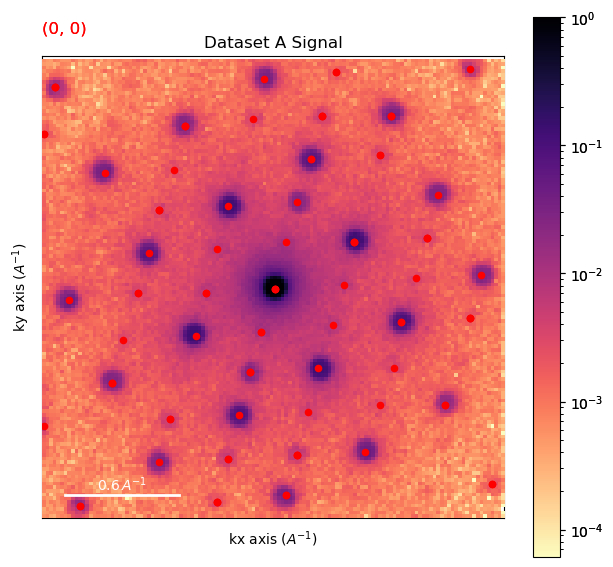

In [6]:
dp.plot(cmap='magma_r', norm='log')
dp.find_peaks(method='laplacian_of_gaussian', min_sigma=2., max_sigma=10., num_sigma=20, threshold=0.0005, overlap=1.0,
              log_scale=False, exclude_border=1, interactive=True)

Run peak finding if the parameters look good, or adjust them before running. This will take a long time (ca 1 h), so choose the parameters carefull before running it on the whole dataset!

In [7]:
t0 = time()
peaks = dp.find_peaks(method='laplacian_of_gaussian', min_sigma=2., max_sigma=10., num_sigma=20, threshold=0.0005,
                      overlap=1.0, log_scale=False, exclude_border=1, interactive=False)
tf = time()
tt = tf-t0
print('Peak finding time [min] '+str(tt/60))

[########################################] | 100% Completed | 92m 21s
Peak finding time [min] 92.59670046567916


Note that even though the data has been calibrated, the peak position is given in pixel values. We will calibrate them later. 

In [8]:
peaks

<BaseSignal, title: Dataset A, dimensions: (512, 512|ragged)>

(Optional) Save the found peak positions. 

In [9]:
np.save(file=folder+'Peaks.npy', arr=peaks.data, allow_pickle=True)

Create peak markers and plot them on top of the signal

In [10]:
dp.add_peak_array_as_markers(peaks.data)

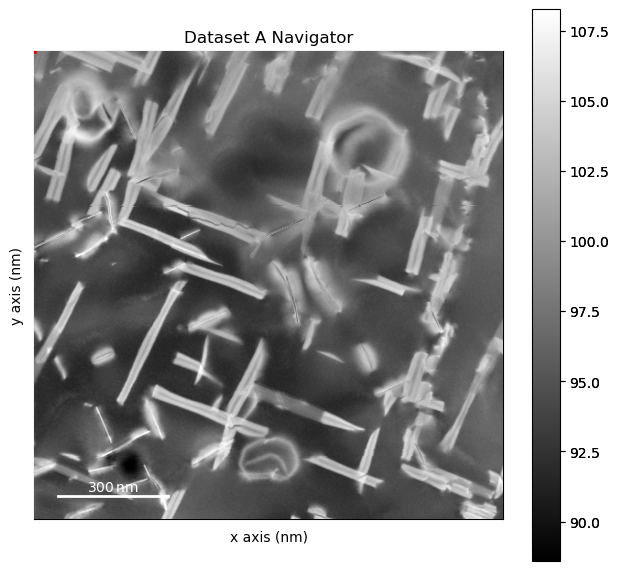

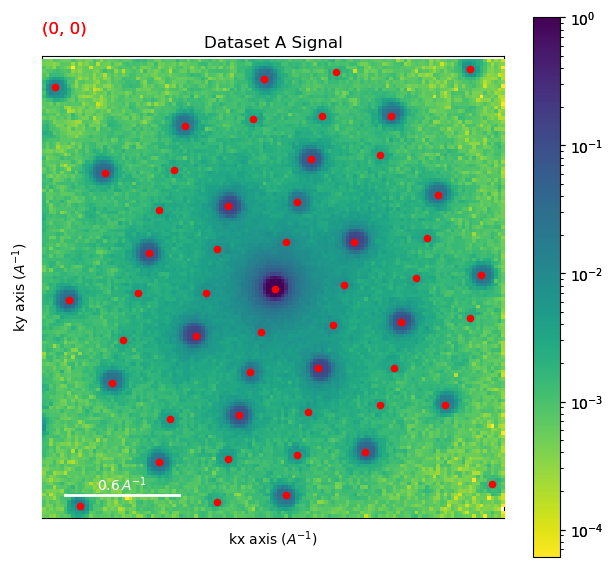

In [11]:
dp.plot(norm='log', cmap='viridis_r')

Refine the peak positions using a centre-of-mass (COM) approach

In [12]:
t0 = time()
peaks_com = dp.peak_position_refinement_com(peaks.data, square_size=8, lazy_result=False, show_progressbar=True)
tf = time()
tt2 = tf-t0
print('Peak refinement time [min] '+str(tt2/60))

[########################################] | 100% Completed | 10m 38s
Peak refinement time [min] 11.214181184768677


(Optional) Save the found peak positions. 

In [13]:
np.save(file=folder+'Peaks_com.npy', arr=peaks_com.data, allow_pickle=True)

Create peak markers and plot them on top of the signal

In [14]:
dp.add_peak_array_as_markers(peaks_com, color='cyan', size=30)

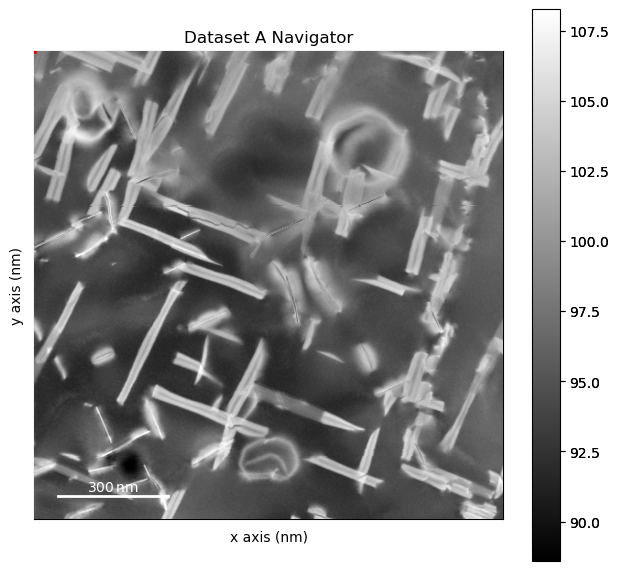

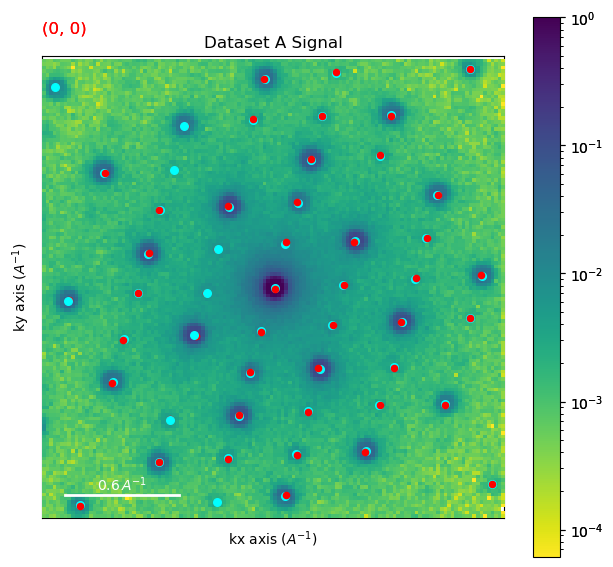

In [15]:
dp.plot(cmap='viridis_r', norm='log')

# 2. Remove all Bragg peaks from the aluminium matrix

Define functions that will be used to remove all vectors that are located within a length of 'distance_th' of any of the reference Al peaks. 

In [16]:
def remove_Al_peaks(peaks_tmp, Al_peaks, distance_th):
    for Al_peak in Al_peaks:
        norm_tmp = np.linalg.norm(peaks_tmp - Al_peak, axis=1)
        try:
            ind_min = np.argmin(norm_tmp)
        except:
            if peaks_tmp.shape[0] == 0:
                return peaks_tmp
            else:
                continue
        if norm_tmp[ind_min] > distance_th:
            continue
        peaks_tmp = np.delete(peaks_tmp, ind_min, axis=0)
    return peaks_tmp


def get_peaks_noAl(peaks, Al_peaks, distance_th):
    peaks_ravel = peaks.ravel()
    n = len(peaks_ravel)
    peaks_noAl = np.zeros((n), dtype='object')
    for i, peak in tqdm(enumerate(peaks_ravel)):
        #if i % int(n * 0.05) == 0:
        #    print('{} percentage done'.format(i / n * 100))
        peaks_noAl[i] = remove_Al_peaks(peak, Al_peaks, distance_th)
    peaks_noAl = np.reshape(peaks_noAl, np.shape(peaks))
    return peaks_noAl

The reference Al peaks are selected manually by finding a single diffraction pattern that has the highest number of Al Bragg peaks detected. To find this, it can be a good idea to plot the number of vectors map. The reference should also include the direct beam, so that the direct beam vector position will also be removed. 

[########################################] | 100% Completed | 265.62 ms


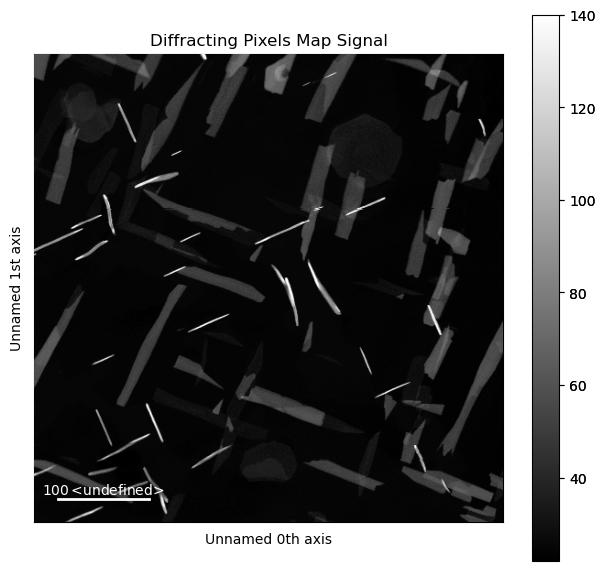

In [17]:
dpx_map= pxm.signals.DiffractionVectors(peaks_com).get_diffracting_pixels_map()
dpx_map.plot()

Here, we locate a good reference pattern with 26 Al peaks.

In [18]:
Al_peaks = peaks_com[215, 274].copy() 

In [19]:
len(Al_peaks)

26

We set the threshold length, 'distance_th', to be 8 pixels. 

In [20]:
distance_th = 8

Remove the Al vectors from each pattern

In [21]:
t0 = time()
peaks_noAl = get_peaks_noAl(peaks_com, Al_peaks, distance_th)
tf = time()
tt3 = tf - t0
print('Peak remove Al time [min] ' + str(tt3 / 60))

262144it [02:27, 1778.04it/s]

Peak remove Al time [min] 2.457239850362142


Save the peak positions after removing all Al peaks

In [22]:
np.save(file=folder + 'Peaks_noAl.npy', arr=peaks_noAl, allow_pickle=True)

Plot again the number of vectors map and see that it has been reduced. Al regions should have 0 or 1 peaks. 

[########################################] | 100% Completed | 239.15 ms


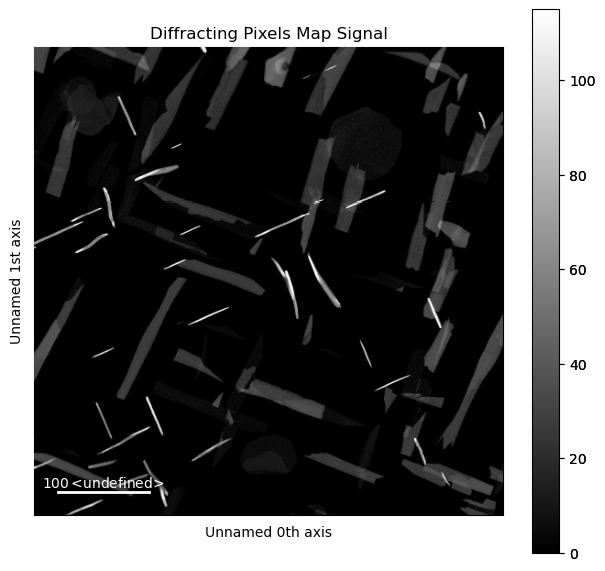

In [23]:
dpx_map_noAl = pxm.signals.DiffractionVectors(peaks_noAl).get_diffracting_pixels_map()
dpx_map_noAl.plot()

### Calibrate the vectors

Extract the calibration, center and offset from the axis_manager of the dataset

In [24]:
calibration = dp.axes_manager[2].scale
center = np.array(dp.axes_manager.signal_shape, dtype='int') / 2
offset = dp.axes_manager[2].offset
dpshape = (512, 512)

Calibrate the peaks positions after refinement, 'peaks_com', and the peaks without Al, 'peaks_noAl'

In [25]:
peaks_com_ravel = peaks_com.ravel()
peaks_com_calibrated = np.array(list(map(
    lambda x: (x - center) * calibration, peaks_com_ravel)), dtype='object')
peaks_com_calibrated = np.reshape(peaks_com_calibrated, dpshape)

peaks_noAl_ravel = peaks_noAl.ravel()
peaks_noAl_calibrated = np.array(list(map(
    lambda x: (x - center) * calibration, peaks_noAl_ravel)), dtype='object')
peaks_noAl_calibrated = np.reshape(peaks_noAl_calibrated, dpshape)

Save the calibrated peaks.

In [26]:
np.save(file=folder+'peaks_com_calibrated.npy', arr=peaks_com_calibrated, allow_pickle=True)
np.save(file=folder+'peaks_noAl_calibrated.npy', arr=peaks_noAl_calibrated, allow_pickle=True)